## Download dataset

In [1]:
!gdown 1GR3IwbvKNuiVXN5E5eMGyEQtT4pP7kCt

Downloading...
From: https://drive.google.com/uc?id=1GR3IwbvKNuiVXN5E5eMGyEQtT4pP7kCt
To: /content/Twitter_Data.csv
100% 20.9M/20.9M [00:00<00:00, 72.9MB/s]


## Import libraries and read dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
PATH = 'Twitter_Data.csv'
df = pd.read_csv(PATH)
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


## Preprocessing data

### Delete missing data

In [6]:
df = df.dropna()

### Build normalization function

In [7]:
def text_normalize(text):
  # Lowerscasting
  text = text.lower()

  # Retweet old acroym 'RT' removal
  text = re.sub(r'^rt[\s]+', '', text)

  # Hyperlinks removal
  text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)

  # Punctuation removal
  text = re.sub(r'[^\w\s]', '', text)

  # Remove stopwords
  stop_words = set(stopwords.words('english'))
  words = text.split()
  words = [word for word in words if word not in stop_words]
  text = ' '.join(words)

  # Stemming
  stemmer = SnowballStemmer('english')
  words = text.split()
  words = [stemmer.stem(word) for word in words]
  text = ' '.join(words)

  return text

### Initialize tf-idf vectorizer

In [8]:
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(df['clean_text']).toarray()

### Add bias to X

In [10]:
intercept = np.ones((X.shape[0], 1))
X_b = np.concatenate((intercept, X), axis=1)

## One-hot encoding label

In [12]:
n_classes = df['category'].nunique()
n_samples = df['category'].size

y = df['category'].to_numpy() + 1
y = y.astype(np.uint8)
y_encoded = np.array(
    [np.zeros(n_classes) for _ in range(n_samples)]
)
y_encoded[np.arange(n_samples), y] = 1

## Split train, val, test

In [13]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X_b, y_encoded,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

## Build importants function

In [14]:
def softmax(z):
  exp_z = np.exp(z)

  return exp_z / exp_z.sum(axis=1)[:, None]

def compute_loss(y_hat, y):
  n = y.size

  return (-1 / n) * np.sum(y * np.log(y_hat))

def predict(X, theta):
  z = np.dot(X, theta)
  y_hat = softmax(z)

  return y_hat

def compute_gradient(X, y, y_hat):
  n = y.size

  return np.dot(X.T, (y_hat - y)) / n

def update_theta(theta, gradient, lr):
  return theta - lr * gradient

def compute_accuracy(X, y, theta):
  y_hat = predict(X, theta)
  acc = (np.argmax(y_hat, axis=1) == np.argmax(y, axis=1)).mean()

  return acc

## Initialize hyperparameters and weights

In [15]:
lr = 0.1
epochs = 200
batch_size = X_train.shape[0]
n_features = X_train.shape[1]

np.random.seed(random_state)
theta = np.random.uniform(
    size = (n_features, n_classes)
)

## Train model

In [16]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
  train_batch_losses = []
  train_batch_accs = []
  val_batch_losses = []
  val_batch_accs = []

  for i in range(0, X_train.shape[0], batch_size):
    X_i = X_train[i:i+batch_size]
    y_i = y_train[i:i+batch_size]

    y_hat = predict(X_i, theta)
    train_loss = compute_loss(y_hat, y_i)

    gradient = compute_gradient(X_i, y_i, y_hat)

    theta = update_theta(theta, gradient, lr)

    train_batch_losses.append(train_loss)

    train_acc = compute_accuracy(X_train, y_train, theta)
    train_batch_accs.append(train_acc)

    y_val_hat = predict(X_val, theta)
    val_loss = compute_loss(y_val_hat, y_val)
    val_batch_losses.append(val_loss)

    val_acc = compute_accuracy(X_val, y_val, theta)
    val_batch_accs.append(val_acc)

  train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
  val_batch_loss = sum(val_batch_losses) / len(val_batch_losses)
  train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
  val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)

  train_losses.append(train_batch_loss)
  train_accs.append(train_batch_acc)
  val_losses.append(val_batch_loss)
  val_accs.append(val_batch_acc)

  print(f'\n EPOCH {epoch+1}: \t Training loss: {train_batch_loss: .3f}\t Validation loss: {val_batch_loss: .3f}')


 EPOCH 1: 	 Training loss:  0.377	 Validation loss:  0.376

 EPOCH 2: 	 Training loss:  0.377	 Validation loss:  0.376

 EPOCH 3: 	 Training loss:  0.377	 Validation loss:  0.376

 EPOCH 4: 	 Training loss:  0.376	 Validation loss:  0.375

 EPOCH 5: 	 Training loss:  0.376	 Validation loss:  0.375

 EPOCH 6: 	 Training loss:  0.376	 Validation loss:  0.375

 EPOCH 7: 	 Training loss:  0.375	 Validation loss:  0.374

 EPOCH 8: 	 Training loss:  0.375	 Validation loss:  0.374

 EPOCH 9: 	 Training loss:  0.375	 Validation loss:  0.374

 EPOCH 10: 	 Training loss:  0.374	 Validation loss:  0.373

 EPOCH 11: 	 Training loss:  0.374	 Validation loss:  0.373

 EPOCH 12: 	 Training loss:  0.374	 Validation loss:  0.373

 EPOCH 13: 	 Training loss:  0.374	 Validation loss:  0.373

 EPOCH 14: 	 Training loss:  0.373	 Validation loss:  0.372

 EPOCH 15: 	 Training loss:  0.373	 Validation loss:  0.372

 EPOCH 16: 	 Training loss:  0.373	 Validation loss:  0.372

 EPOCH 17: 	 Training loss:  0.3

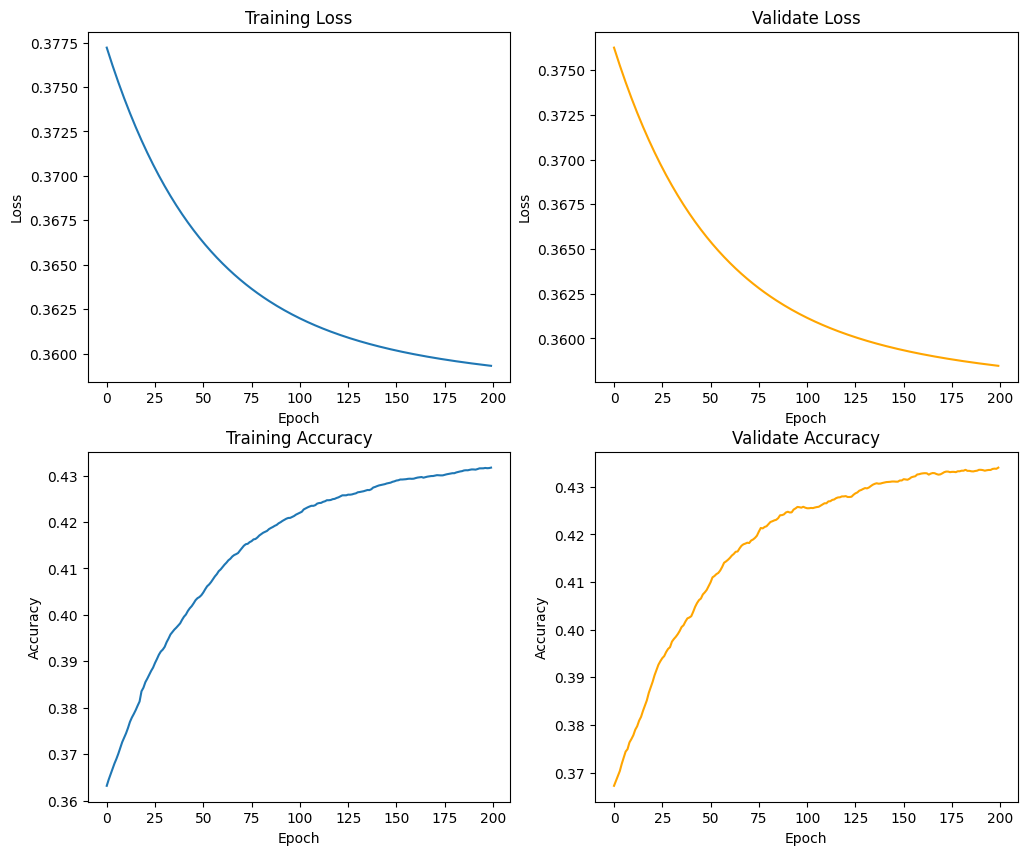

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, 'orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validate Loss')

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, 'orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validate Accuracy')

plt.show()

## Evaluate model

In [18]:
val_set_acc = compute_accuracy(X_val, y_val, theta)
test_set_acc = compute_accuracy(X_test, y_test, theta)

print(f'Validation set accuracy: {val_set_acc}')
print(f'Test set accuracy: {test_set_acc}')

Validation set accuracy: 0.4340369393139842
Test set accuracy: 0.4322881511934712
